In [1]:
# import system libs
import os
import itertools
from PIL import Image # pillow

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Generate data paths with labels
train_data_dir = 'dataset\Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis=1)

In [3]:
train_df.head()

,filepaths,labels
0,dataset\Training\glioma\Tr-glTr_0000.jpg,glioma
1,dataset\Training\glioma\Tr-glTr_0001.jpg,glioma
2,dataset\Training\glioma\Tr-glTr_0002.jpg,glioma
3,dataset\Training\glioma\Tr-glTr_0003.jpg,glioma
4,dataset\Training\glioma\Tr-glTr_0004.jpg,glioma


In [6]:
# Generate data paths with labels
test_data_dir = 'dataset\Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
# Validate and test dataframes
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [6]:
# Crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


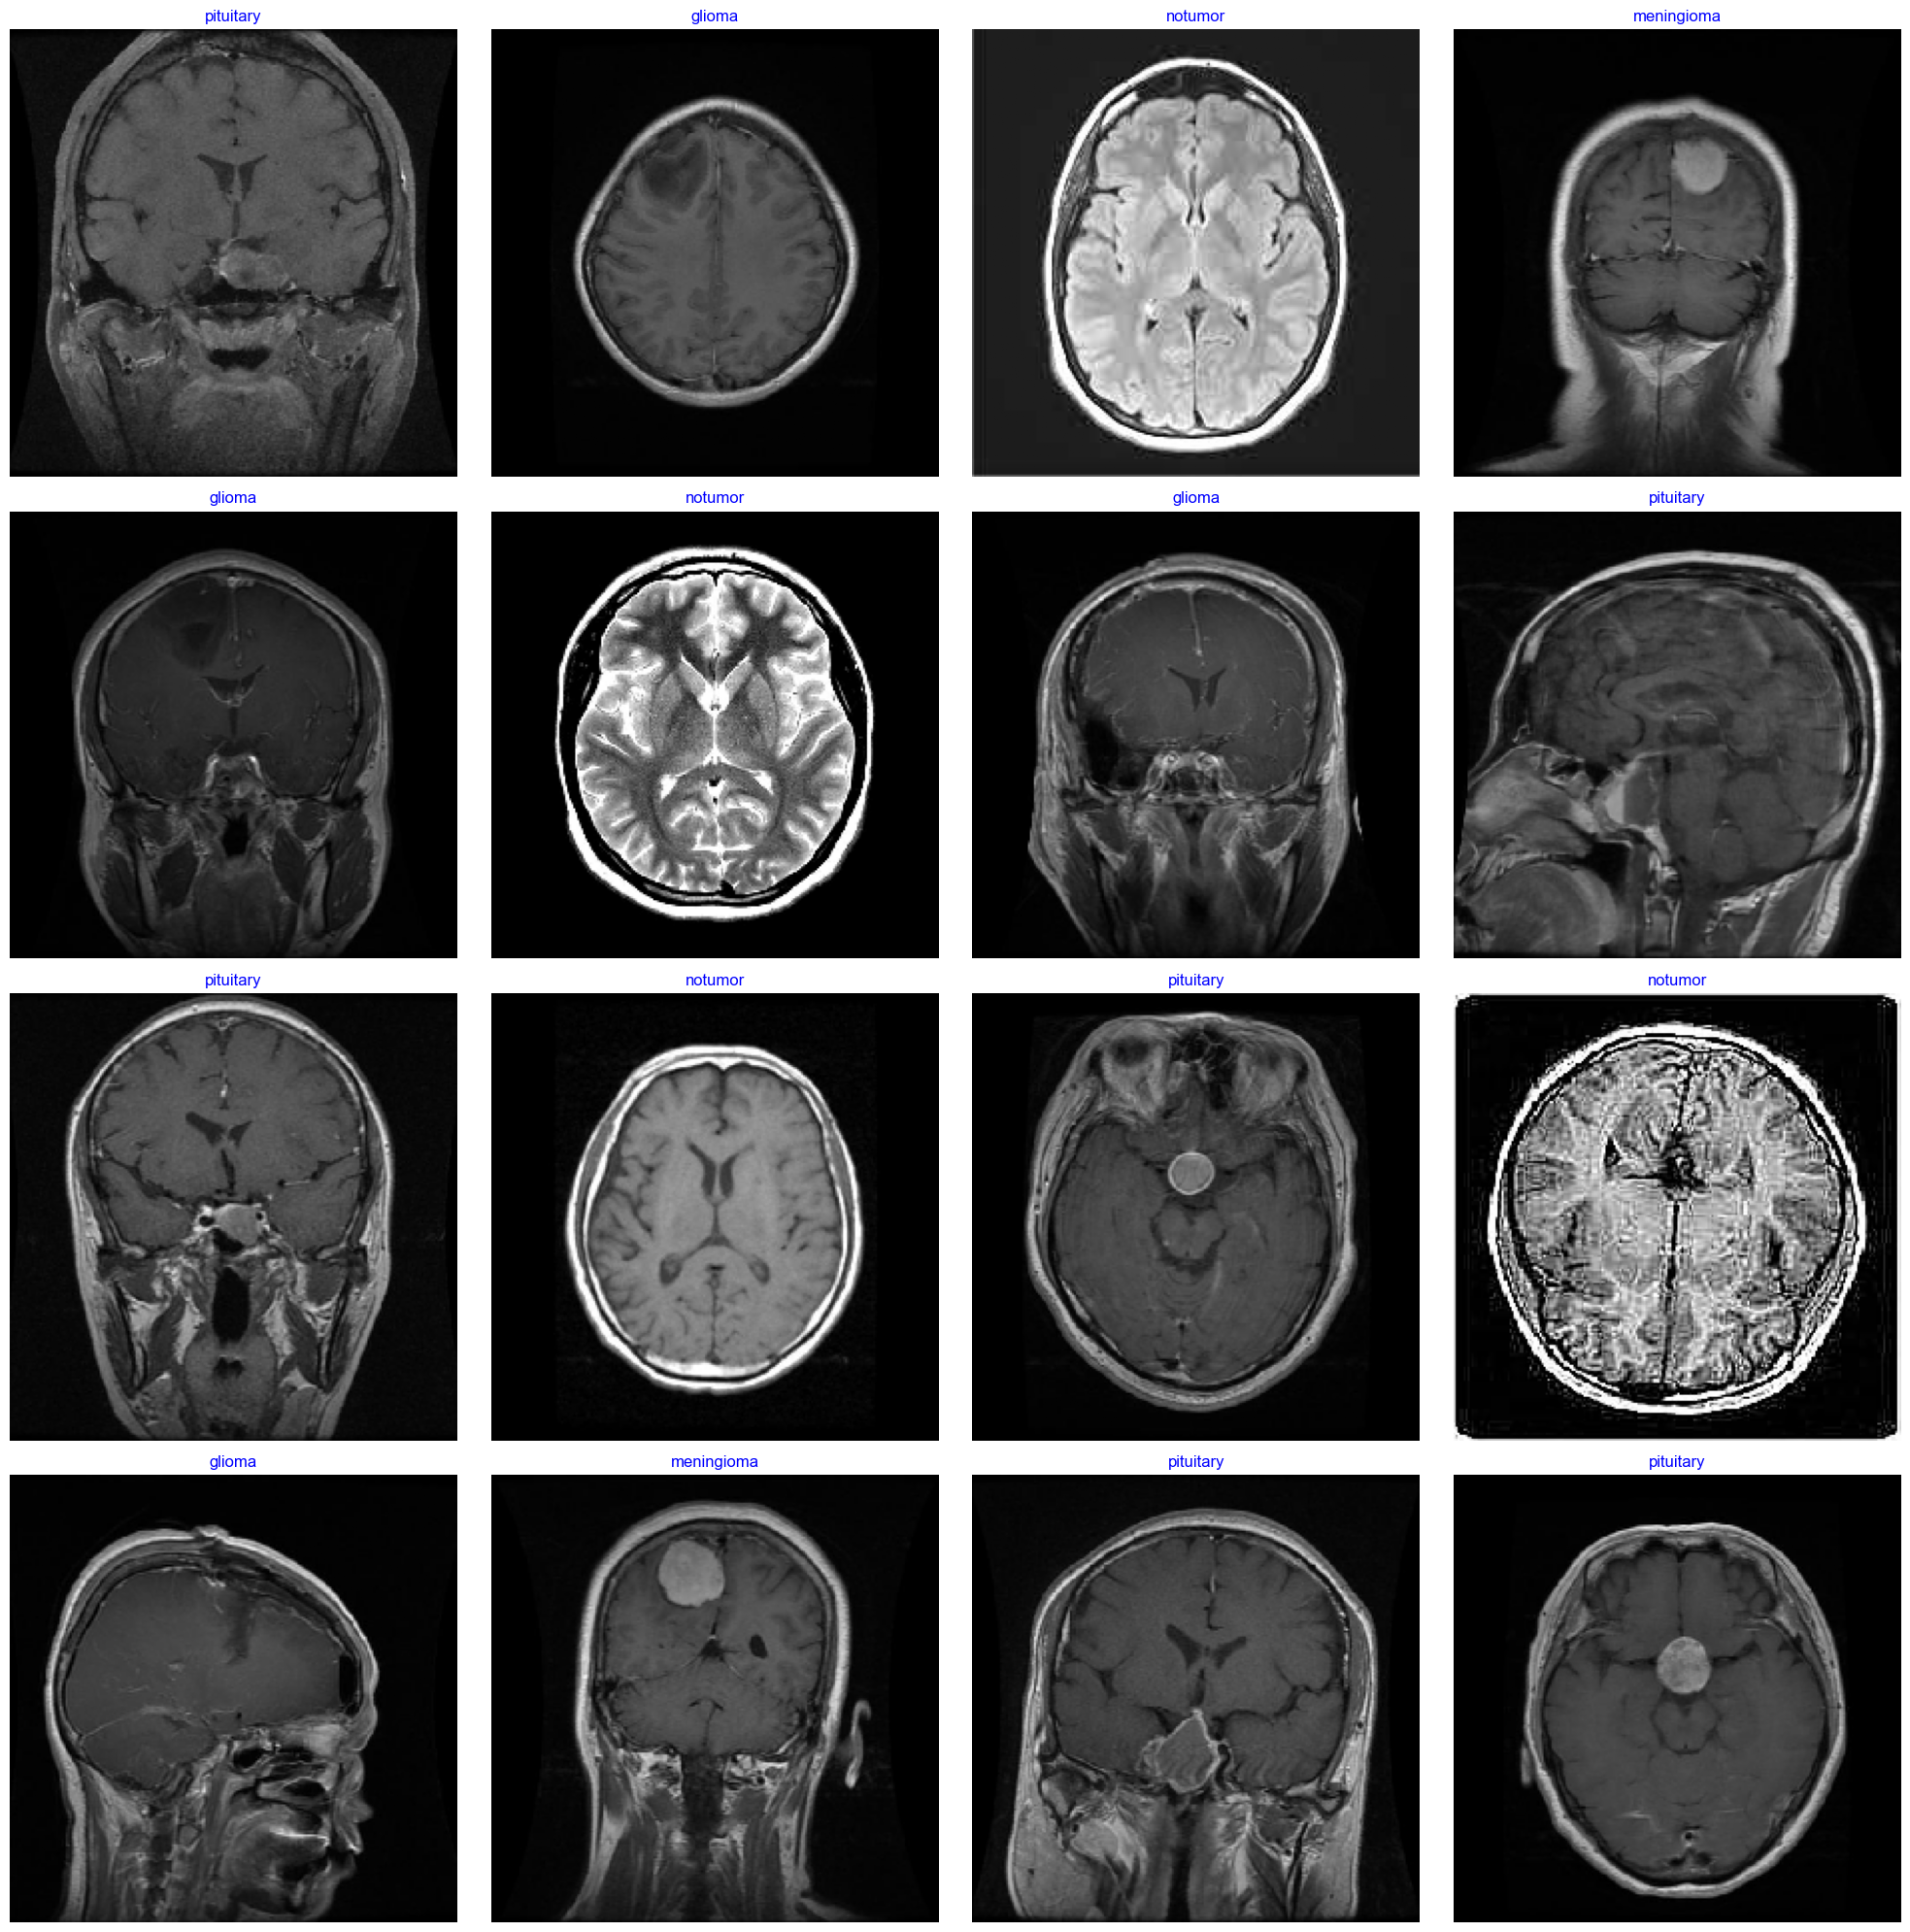

In [7]:
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes), classes names: string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255  # scales data to range (0 -255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image 
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [9]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 [==============================] - 3496s 10s/step - loss: 1.8452 - accuracy: 0.6117 - val_loss: 0.6950 - val_accuracy: 0.7160
Epoch 2/10
357/357 [==============================] - 1947s 5s/step - loss: 0.4379 - accuracy: 0.8346 - val_loss: 0.4396 - val_accuracy: 0.8076
Epoch 3/10
357/357 [==============================] - 1837s 5s/step - loss: 0.3176 - accuracy: 0.8916 - val_loss: 0.4086 - val_accuracy: 0.8260
Epoch 4/10
357/357 [==============================] - 2448s 7s/step - loss: 0.2599 - accuracy: 0.9081 - val_loss: 0.3835 - val_accuracy: 0.8534
Epoch 5/10
357/357 [==============================] - 2231s 6s/step - loss: 0.1870 - accuracy: 0.9347 - val_loss: 0.2170 - val_accuracy: 0.9084
Epoch 6/10
357/357 [==============================] - 1767s 5s/step - loss: 0.1518 - accuracy: 0.9473 - val_loss: 0.1942 - val_accuracy: 0.9405
Epoch 7/10
357/357 [==============================] - 1700s 5s/step - loss: 0.1265 - accuracy: 0.9576 - val_loss: 0.2731 - val_accuracy

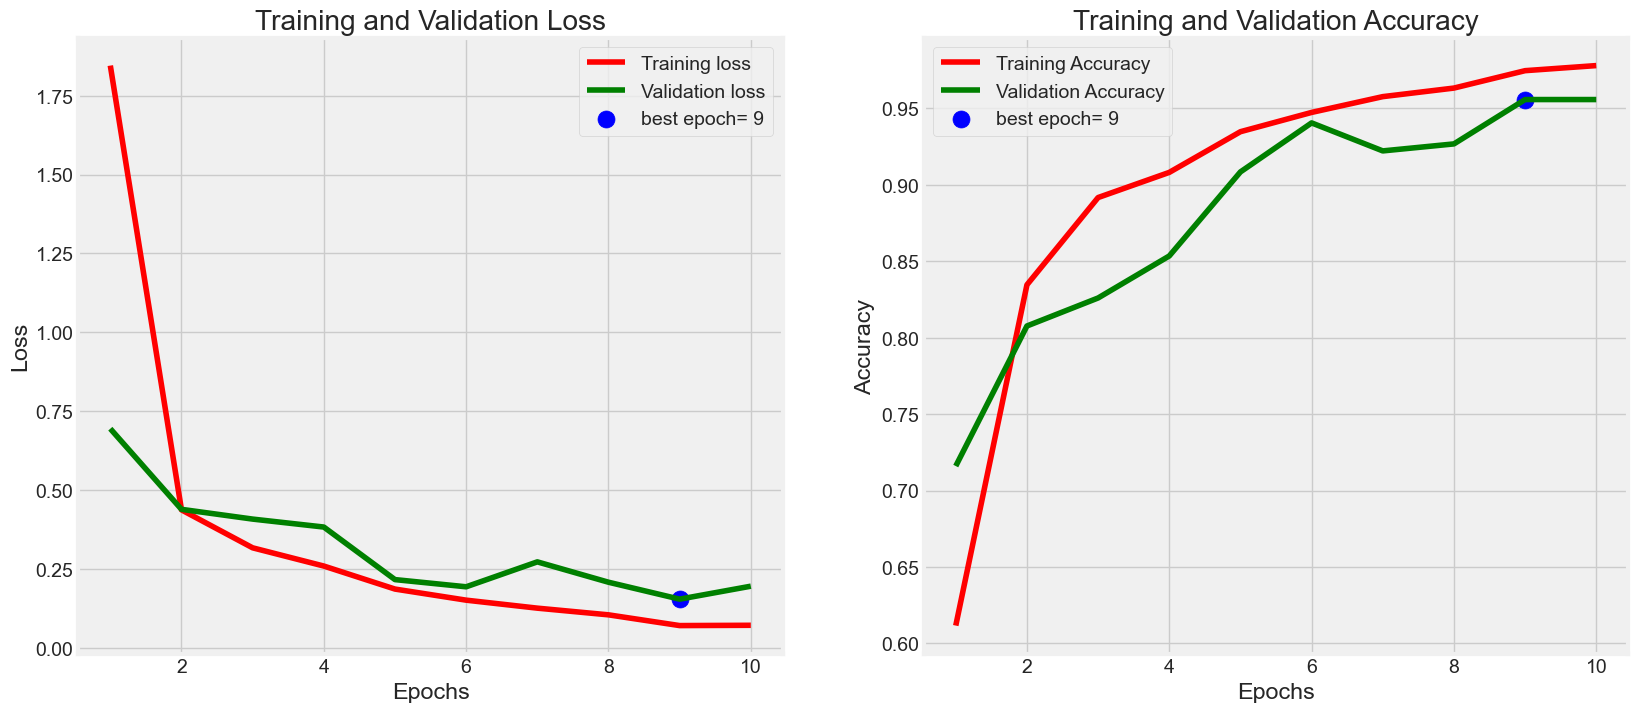

In [10]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [11]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 44s 1s/step - loss: 0.1487 - accuracy: 0.9482
Train Loss:  0.061066802591085434
Train Accuracy:  0.9791666865348816
--------------------
Validation Loss:  0.19608697295188904
Validation Accuracy:  0.9557251930236816
--------------------
Test Loss:  0.14869406819343567
Test Accuracy:  0.9481707215309143


In [12]:
preds = model.predict_generator(test_gen)  # [0.00001, 95.12312, 0.0021, 3.12313]
y_pred = np.argmax(preds, axis=1) 

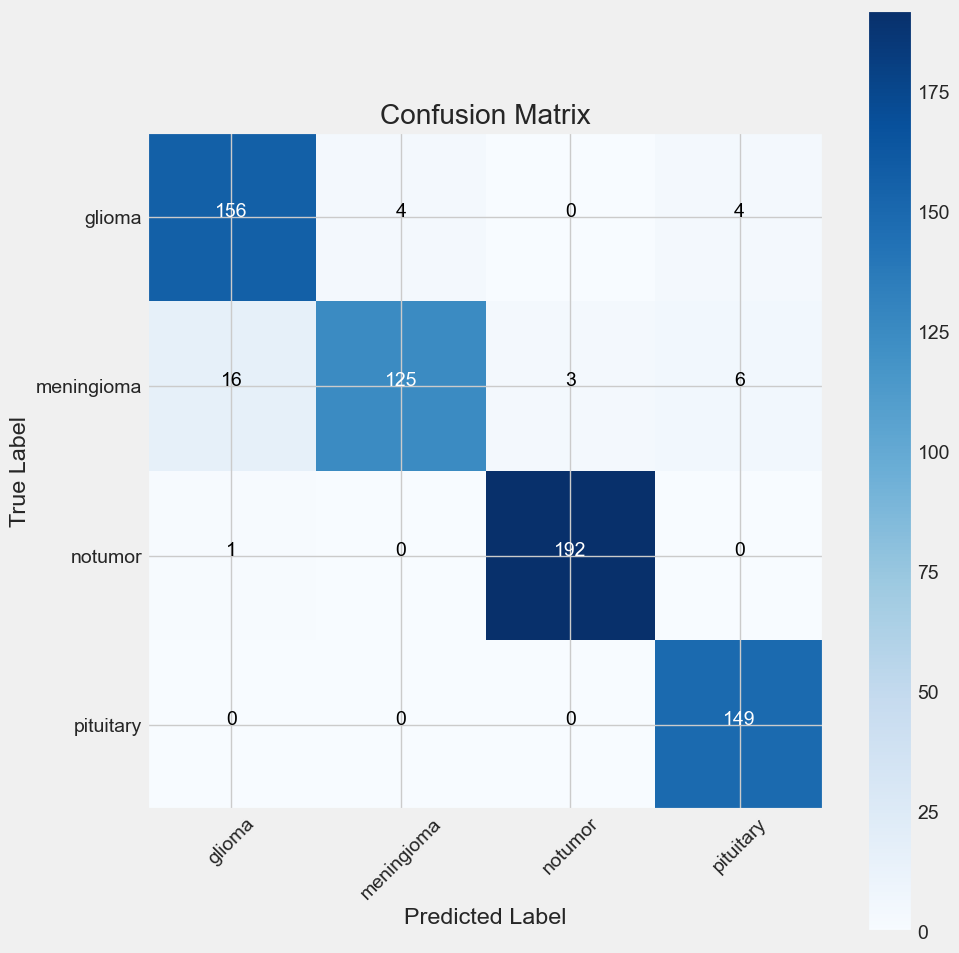

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.90      0.95      0.93       164
  meningioma       0.97      0.83      0.90       150
     notumor       0.98      0.99      0.99       193
   pituitary       0.94      1.00      0.97       149

    accuracy                           0.95       656
   macro avg       0.95      0.94      0.94       656
weighted avg       0.95      0.95      0.95       656



In [15]:
#Save the model
model.save('Brain Tumors.h5')

In [2]:
loaded_model = tf.keras.models.load_model('Brain Tumors.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

1/1 [==============================] - 1s 555ms/step


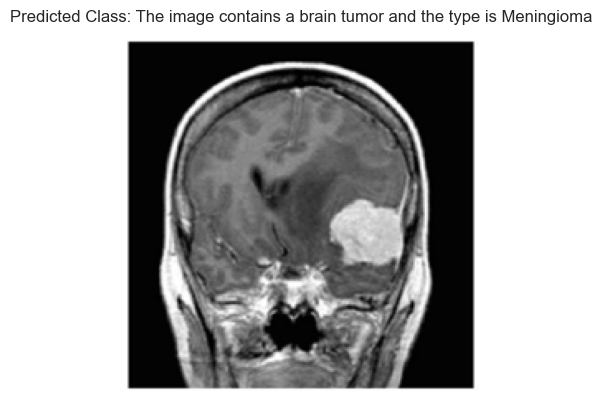

In [3]:
# Define classes at the beginning of your script
classes = ['The image contains a brain tumor and the type is Glioma', 'The image contains a brain tumor and the type is Meningioma', 'The image does not contain a brain tumor.', 'The image contains a brain tumor and the type is Pituitary']
from tensorflow.keras.preprocessing import image as kimage

# Load the image
image_path = 'dataset\Testing\meningioma\Te-me_0014.jpg'  # Replace 'path_to_your_image.jpg' with the actual path
image = Image.open(image_path)

# Preprocess the image

img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = classes[predicted_class_index]

# Display the image with the predicted class
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


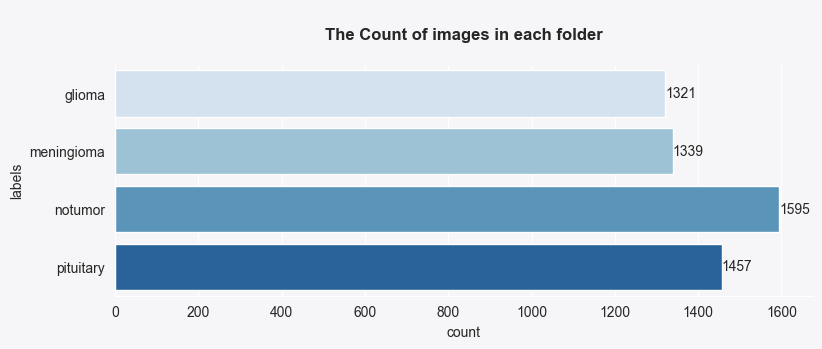

In [5]:
fig,ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for i in ["top","right"]:
    ax.spines[i].set_visible(False)
    
x = sns.countplot(data=train_df, y=train_df["labels"],palette='Blues')
for container in x.containers:
    x.bar_label(container)
plt.title("\nThe Count of images in each folder\n",weight="bold");

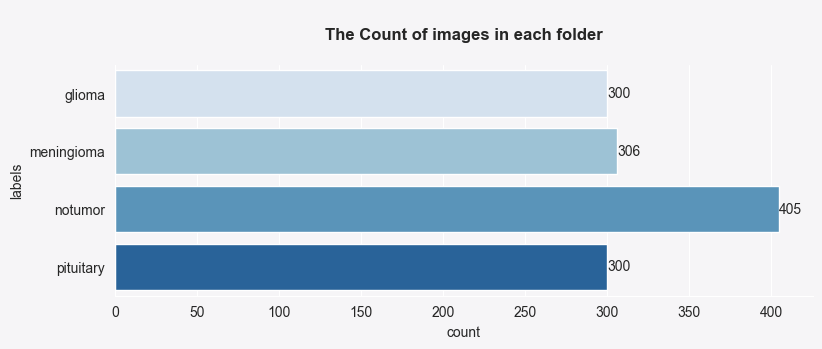

In [7]:
fig,ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for i in ["right","top"]:
    ax.spines[i].set_visible(False)
    
i=sns.countplot(data=ts_df,y=ts_df["labels"],palette='Blues')
for container in i.containers:
    i.bar_label(container)
    
plt.title("\nThe Count of images in each folder\n",weight="bold");